In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit, least_squares, minimize
import matplotlib

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 14

In [2]:
# Load the major plot
path = r"G:\Shared drives\L10237-TG-10nm\All Document\fig3_processing\data_ratio"

qt_2d_12_right = np.load(path + r"\12tg_right_2d_qt.npy")
qomega_2d_12_right = np.load(path + r"\12tg_right_2d_qomega.npy")
qarray_2d_12_right = np.load(path + r"\12tg_right_2d_qarray.npy") * np.pi * 2
phonon_2d_12_right = np.load(path + r"\12tg_right_2d_LA.npy")
phonon_2d_12_right_to = np.load(path + r"\12tg_right_2d_TO.npy")
time_right = np.load(path + r"\12nm_right_1d_t.npy")
omega_right = np.load(path + r'\12nm_right_1d_omega_v2.npy')

# Load the major plot
qt_2d_12_left = np.load(path + r"\12tg_left_2d_qt.npy")
qomega_2d_12_left = np.load(path + r"\12tg_left_2d_qomega.npy")
qarray_2d_12_left = np.load(path + r"\12tg_left_2d_qarray.npy") * np.pi * 2
phonon_2d_12_left = np.load(path + r"\12tg_left_2d_LA.npy")
phonon_2d_12_left_to = np.load(path + r"\12tg_left_2d_TO.npy")
time_left = np.load(path + r"\12nm_left_1d_t.npy")
omega_left = np.load(path + r'\12nm_left_1d_omega_v2.npy')

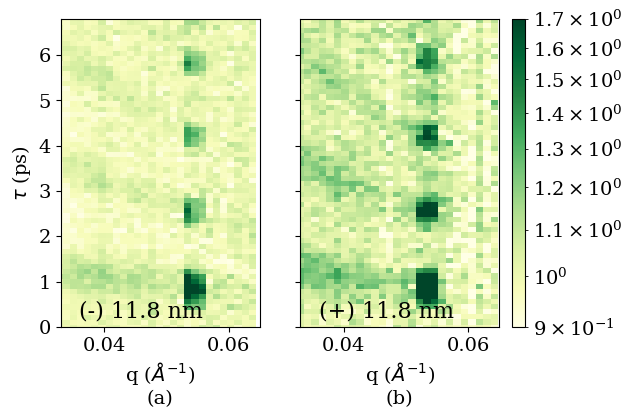

In [3]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figheight(4)
fig.set_figwidth(6.5)

ax1 = axes[0]
ax2 = axes[1]

xlim = [0.033, 0.065]
vmax_m = 1.7
vmin_m = 0.9
cmap = 'BuPu'
#cmap='cividis'
cmap = 'magma'
cmap = 'YlGn'
# --------------------------------------------------------------
im1 = ax1.imshow(qt_2d_12_left,
                 cmap=cmap,
                 aspect='auto',
                 norm=LogNorm(vmin=vmin_m, vmax=vmax_m),
                 #vmin=vmin, vmax=vmax,
                 origin='lower',
                 extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                         time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
ax1.set_xlabel(r"q ($\AA^{-1}$)" + "\n(a)")
ax1.set_ylim([0, 6.8])
ax1.set_xlim(xlim)
ax1.set_ylabel(r"$\tau$ (ps)")

im2 = ax2.imshow(qt_2d_12_right,
                 cmap=cmap,
                 aspect='auto',
                 norm=LogNorm(vmin=vmin_m, vmax=vmax_m),
                 #vmin=vmin, vmax=vmax,
                 origin='lower',
                 extent=[qarray_2d_12_right[0], qarray_2d_12_right[-1],
                         time_right[0] - 3.67192887, time_right[-1] - 3.67192887, ])
ax2.set_xlabel(r"q ($\AA^{-1}$)" + "\n(b)")
ax2.set_ylim([0, 6.8])
ax2.set_yticklabels('')
ax2.set_xlim(xlim)
# -----------------------------------
ax1.text(x=0.036, y=0.2, s='(-) 11.8 nm', color='k', fontsize=16)
ax2.text(x=0.036, y=0.2, s='(+) 11.8 nm', color='k', fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.11, 0.02, 0.771])
cbar_img = fig.colorbar(im2, cax=cbar_ax, ticks=[10, 30, 50, 70])
cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])

#plt.savefig("./fig3.png", dpi=300, bbox_inches='tight')
plt.show()

In [4]:
## Create mask for the left peak
start_time_left = 3.6
stop_time_left = 10.5

start_q_left = 0.034
stop_q_left = 0.05

mask_left = np.ones_like(qt_2d_12_left, dtype=bool)
mask_left[:, :] *= np.logical_and(time_left > start_time_left, time_left < stop_time_left)[:, np.newaxis]
mask_left[:, :] *= np.logical_and(qarray_2d_12_left > start_q_left, qarray_2d_12_left < stop_q_left)[np.newaxis:]

measure_left = np.copy(qt_2d_12_left)
t_left = (time_left - 3.67192887)[:, np.newaxis]
q_left = qarray_2d_12_left[np.newaxis, :]

# ------------------------------------
start_time_right = 3.6
stop_time_right = 10.5

start_q_right = 0.034
stop_q_right = 0.05

mask_right = np.ones_like(qt_2d_12_right, dtype=bool)
mask_right[:, :] *= np.logical_and(time_right > start_time_right, time_right < stop_time_right)[:, np.newaxis]
mask_right[:, :] *= np.logical_and(qarray_2d_12_right > start_q_right, qarray_2d_12_right < stop_q_right)[np.newaxis:]

measure_right = np.copy(qt_2d_12_right)
t_right = (time_right - 3.67192887)[:, np.newaxis]
q_right = qarray_2d_12_right[np.newaxis, :]

"""
I would like to perform the following fitting

signal = (A exp(-q^2 sigma^2 / 2) / q^2 * exp(-t/taus) * (1-cos(q v t)))^2 + c
"""


def loss_fun(x):
    """
    x[0] = A
    x[1] = sigma^2 / 2   A^2
    x[2] = 1/taus        ps^-1 
    x[3] = v         3000 m/s = 3e3 * 10e10 / 1e12 = 30 A/ps
    x[4] = c     unitless
    """
    # Get the loss from the left peak
    val_left = x[0] * np.exp(- q_left ** 2 * x[1])  #* q
    val_left = val_left * np.exp(-t_left * x[2]) * (1 - np.cos(q_left * x[3] * t_left))
    val_left = np.square(val_left) + x[4]

    diff = (val_left - measure_left)[mask_left]
    val_left = np.sum(np.square(diff))

    val_right = x[5] * np.exp(- q_right ** 2 * x[1])  #* q
    val_right = val_right * np.exp(- t_right * x[2]) * (1 - np.cos(q_right * x[3] * t_right))
    val_right = np.square(val_right) + x[6]

    diff = (val_right - measure_right)[mask_right]
    val_right = np.sum(np.square(diff))

    return val_left + val_right


res_both = minimize(loss_fun,
                    x0=np.array([2.62241549e+00, 3.26725659e+02, 1.11638604e-01, 7.31707291e+01, -1.26376927e+00,
                                 2.62241549e+00, -1.26376927e+00], ),
                    method=None,
                    bounds=((0.00001, 10000,),
                            (0.0, 400.,),
                            (0.00001, 4.),
                            (1, 100.),
                            (-10, 1000),
                            (0.00001, 10000,),
                            (-10, 1000),
                            ),
                    )
print(res_both.success)
print(res_both.x)
print(np.sqrt(2 * res_both.x[1]))

True
[3.27971968e-01 3.26797201e+02 9.07140783e-02 7.35252934e+01
 9.78178283e-01 4.07794315e-01 1.02737464e+00]
25.565492417215506


In [5]:
# Get the fitted value
amplitude_left = res_both.x[0] * np.exp(- q_left ** 2 * res_both.x[1])  #* q
fit_left = amplitude_left * np.exp(-t_left * res_both.x[2]) * (1 - np.cos(q_left * res_both.x[3] * t_left))
fit_left = np.square(fit_left) + res_both.x[4]

# Get the fitted value
amplitude_right = res_both.x[5] * np.exp(- q_right ** 2 * res_both.x[1])  #* q
fit_right = amplitude_right * np.exp(-t_right * res_both.x[2]) * (1 - np.cos(q_right * res_both.x[3] * t_right))
fit_right = np.square(fit_right) + res_both.x[4]

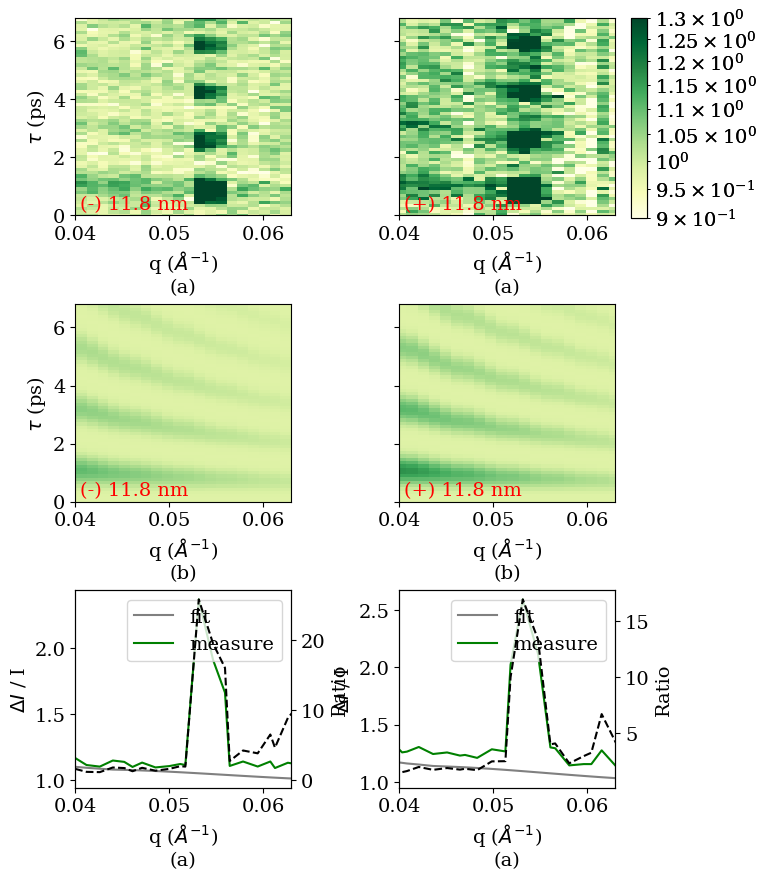

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=3, gridspec_kw={"hspace": 0.45,
                                                        "wspace": 0.5,
                                                        })
fig.set_figheight(10)
fig.set_figwidth(8)

xlim = [0.04, 0.063]
vmax_m = 1.3
vmin_m = 0.9
cmap = 'BuPu'
#cmap='cividis'
cmap = 'magma'
cmap = 'YlGn'

# ------------------------------------------------------------------------------------------
# Plot the left figure
im1 = axes[0, 0].imshow(qt_2d_12_left,
                        cmap=cmap,
                        aspect='auto',
                        norm=LogNorm(vmin=vmin_m, vmax=vmax_m),
                        origin='lower',
                        extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                                time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
axes[0, 0].set_xlabel(r"q ($\AA^{-1}$)" + "\n(a)")
axes[0, 0].set_ylim([0, 6.8])
axes[0, 0].set_xlim(xlim)
axes[0, 0].set_ylabel(r"$\tau$ (ps)")

im2 = axes[1, 0].imshow(fit_left,
                        cmap=cmap,
                        aspect='auto',
                        norm=LogNorm(vmin=vmin_m, vmax=vmax_m),
                        origin='lower',
                        extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                                time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
axes[1, 0].set_xlabel(r"q ($\AA^{-1}$)" + "\n(b)")
axes[1, 0].set_ylim([0, 6.8])
axes[1, 0].set_ylabel(r"$\tau$ (ps)")
axes[1, 0].set_xlim(xlim)

# Plot the left figure
axes_twin02 = axes[2, 0].twinx()
axes[2, 0].plot(qarray_2d_12_left, np.max(fit_left, axis=0), label='fit', c='gray')
axes[2, 0].plot(qarray_2d_12_left, np.max(qt_2d_12_left, axis=0), label='measure', c='g')
axes_twin02.plot(qarray_2d_12_left, (np.max(qt_2d_12_left, axis=0) - 1) / (np.max(fit_left, axis=0) - 1), label='ratio',
                 c='k', linestyle='--')
axes[2, 0].legend()
axes[2, 0].set_xlim(xlim)
axes[2, 0].set_xlabel(r"q ($\AA^{-1}$)" + "\n(a)")
axes[2, 0].set_ylabel("$\Delta I$ / I")
axes_twin02.set_ylabel("Ratio")
# ------------------------------------------------------------------------------------------
# Plot the left figure
im3 = axes[0, 1].imshow(qt_2d_12_right,
                        cmap=cmap,
                        aspect='auto',
                        norm=LogNorm(vmin=vmin_m, vmax=vmax_m),
                        origin='lower',
                        extent=[qarray_2d_12_right[0], qarray_2d_12_right[-1],
                                time_right[0] - 3.67192887, time_right[-1] - 3.67192887, ])
axes[0, 1].set_xlabel(r"q ($\AA^{-1}$)" + "\n(a)")
axes[0, 1].set_ylim([0, 6.8])
axes[0, 1].set_xlim(xlim)
axes[0, 1].set_yticklabels('')

im4 = axes[1, 1].imshow(fit_right,
                        cmap=cmap,
                        aspect='auto',
                        norm=LogNorm(vmin=vmin_m, vmax=vmax_m),
                        origin='lower',
                        extent=[qarray_2d_12_right[0], qarray_2d_12_right[-1],
                                time_right[0] - 3.67192887, time_right[-1] - 3.67192887, ])
axes[1, 1].set_xlabel(r"q ($\AA^{-1}$)" + "\n(b)")
axes[1, 1].set_ylim([0, 6.8])
axes[1, 1].set_yticklabels('')
axes[1, 1].set_xlim(xlim)

# Plot the left figure
axes_twin21 = axes[2, 1].twinx()
axes[2, 1].plot(qarray_2d_12_right, np.max(fit_right, axis=0), label='fit', c='gray')
axes[2, 1].plot(qarray_2d_12_right, np.max(qt_2d_12_right, axis=0), label='measure', c='g')
axes_twin21.plot(qarray_2d_12_right, (np.max(qt_2d_12_right, axis=0) - 1) / (np.max(fit_right, axis=0) - 1),
                 label='ratio',
                 c='k', linestyle='--')
axes[2, 1].legend()
axes[2, 1].set_xlim(xlim)
axes[2, 1].set_xlabel(r"q ($\AA^{-1}$)" + "\n(a)")
axes[2, 1].set_ylabel("$\Delta I$ / I")
axes_twin21.set_ylabel("Ratio")

# Plot the left figure
# -----------------------------------
axes[0, 0].text(x=0.0405, y=0.2, s='(-) 11.8 nm', color='r')
axes[1, 0].text(x=0.0405, y=0.2, s='(-) 11.8 nm', color='r')

axes[0, 1].text(x=0.0405, y=0.2, s='(+) 11.8 nm', color='r')
axes[1, 1].text(x=0.0405, y=0.2, s='(+) 11.8 nm', color='r')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.68, 0.02, 0.2])
cbar_img = fig.colorbar(im4, cax=cbar_ax, ticks=[10, 30, 50, 70])
cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.68, 0.02, 0.2])
cbar_img = fig.colorbar(im4, cax=cbar_ax, ticks=[10, 30, 50, 70])
cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])

#plt.savefig("2d_fit.png", dpi=300, bbox_inches='tight')
#plt.tight_layout()
plt.show()

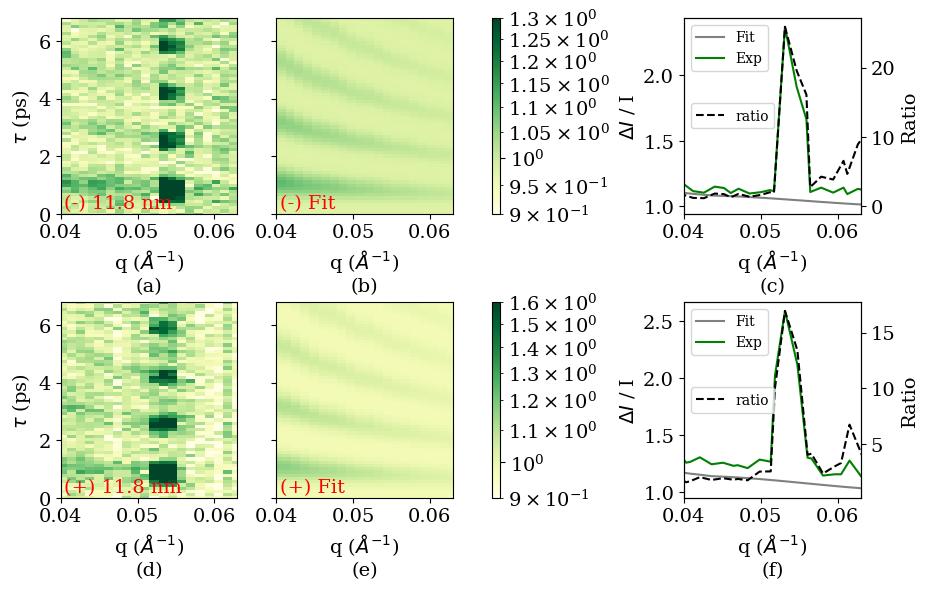

In [25]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 5,  width_ratios=(2, 2, 0.1, 1.2, 2), height_ratios=(1, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.3,
                      hspace=0.45)
axes = np.array([[fig.add_subplot(gs[0, x]) for x in [0, 1, 2, 4]],
                 [fig.add_subplot(gs[1, x]) for x in [0, 1, 2, 4]]])


xlim = [0.04, 0.063]

vmax_m = 1.3
vmin_m = 0.9
vmax_p = 1.6
vmin_p = 0.9

cmap = 'YlGn'

# ------------------------------------------------------------------------------------------
# Plot the left figure
im1 = axes[0, 0].imshow(qt_2d_12_left,
                        cmap=cmap,
                        aspect='auto',
                        norm=LogNorm(vmin=vmin_m, vmax=vmax_m),
                        origin='lower',
                        extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                                time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
axes[0, 0].set_xlabel(r"q ($\AA^{-1}$)" + "\n(a)")
axes[0, 0].set_ylim([0, 6.8])
axes[0, 0].set_xlim(xlim)
axes[0, 0].set_ylabel(r"$\tau$ (ps)")

im2 = axes[0, 1].imshow(fit_left,
                        cmap=cmap,
                        aspect='auto',
                        norm=LogNorm(vmin=vmin_m, vmax=vmax_m),
                        origin='lower',
                        extent=[qarray_2d_12_left[0], qarray_2d_12_left[-1],
                                time_left[0] - 3.67192887, time_left[-1] - 3.67192887, ])
axes[0, 1].set_xlabel(r"q ($\AA^{-1}$)" + "\n(b)")
axes[0, 1].set_ylim([0, 6.8])
axes[0, 1].set_yticklabels('')
axes[0, 1].set_xlim(xlim)

# Plot the left figure
axes_twin02 = axes[0, 3].twinx()
axes[0, 3].plot(qarray_2d_12_left, np.max(fit_left, axis=0), label='Fit', c='gray')
axes[0, 3].plot(qarray_2d_12_left, np.max(qt_2d_12_left, axis=0), label='Exp', c='g')
axes_twin02.plot(qarray_2d_12_left, (np.max(qt_2d_12_left, axis=0) - 1) / (np.max(fit_left, axis=0) - 1), label='ratio',
                 c='k', linestyle='--')
axes[0, 3].legend(loc='upper left', fontsize=10)
axes_twin02.legend(loc='center left', fontsize=10)
axes[0, 3].set_xlim(xlim)
axes[0, 3].set_xlabel(r"q ($\AA^{-1}$)" + "\n(c)")
axes[0, 3].set_ylabel("$\Delta I$ / I")
axes_twin02.set_ylabel("Ratio")
# ------------------------------------------------------------------------------------------
# Plot the left figure
im3 = axes[1, 0].imshow(qt_2d_12_right,
                        cmap=cmap,
                        aspect='auto',
                        norm=LogNorm(vmin=vmin_p, vmax=vmax_p),
                        origin='lower',
                        extent=[qarray_2d_12_right[0], qarray_2d_12_right[-1],
                                time_right[0] - 3.67192887, time_right[-1] - 3.67192887, ])
axes[1, 0].set_xlabel(r"q ($\AA^{-1}$)" + "\n(d)")
axes[1, 0].set_ylim([0, 6.8])
axes[1, 0].set_xlim(xlim)
axes[1, 0].set_ylabel(r"$\tau$ (ps)")
    
im4 = axes[1, 1].imshow(fit_right,
                        cmap=cmap,
                        aspect='auto',
                        norm=LogNorm(vmin=vmin_p, vmax=vmax_p),
                        origin='lower',
                        extent=[qarray_2d_12_right[0], qarray_2d_12_right[-1],
                                time_right[0] - 3.67192887, time_right[-1] - 3.67192887, ])
axes[1, 1].set_xlabel(r"q ($\AA^{-1}$)" + "\n(e)")
axes[1, 1].set_ylim([0, 6.8])
axes[1, 1].set_yticklabels('')
axes[1, 1].set_xlim(xlim)

# Plot the left figure
axes_twin21 = axes[1, 3].twinx()
axes[1, 3].plot(qarray_2d_12_right, np.max(fit_right, axis=0), label='Fit', c='gray')
axes[1, 3].plot(qarray_2d_12_right, np.max(qt_2d_12_right, axis=0), label='Exp', c='g')
axes_twin21.plot(qarray_2d_12_right, (np.max(qt_2d_12_right, axis=0) - 1) / (np.max(fit_right, axis=0) - 1),
                 label='ratio',
                 c='k', linestyle='--')
axes[1, 3].legend(loc='upper left', fontsize=10)
axes_twin21.legend(loc='center left', fontsize=10)
axes[1, 3].set_xlim(xlim)
axes[1, 3].set_xlabel(r"q ($\AA^{-1}$)" + "\n(f)")
axes[1, 3].set_ylabel("$\Delta I$ / I")
axes_twin21.set_ylabel("Ratio")

# Plot the left figure
# -----------------------------------
axes[0, 0].text(x=0.0405, y=0.2, s='(-) 11.8 nm', color='r')
axes[0, 1].text(x=0.0405, y=0.2, s='(-) Fit', color='r')

axes[1, 0].text(x=0.0405, y=0.2, s='(+) 11.8 nm', color='r')
axes[1, 1].text(x=0.0405, y=0.2, s='(+) Fit', color='r')

cbar_img = fig.colorbar(im2, cax=axes[0,2], shrink=0.001)
#cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])

cbar_img = fig.colorbar(im4, cax=axes[1,2], )
#cbar_img.ax.set_yticklabels(['10', '30', '50', '70'])

plt.savefig("2d_fit.png", dpi=300, bbox_inches='tight')
plt.show()